## Calculating the analytical solution for the oscillating basin

Author: WaveHello <br>
Last Modified: 06/24/2024 <br>

**Purpose**: <br>
Calculate and recreate the analytical solution presented in the Non-Hydrostatic xBeach manual. This sheet only calculates the analytical solution.

**Link to the xBeach Non-Hydrostatic manual** <br>
[Link](https://oss.deltares.nl/documents/4142077/4199062/non-hydrostatic_report_draft.pdf/eadc1aff-6e19-6e82-2747-3c11c30457ee?t=1624871720408)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import sys
PI = np.pi

### Import the functions

In [2]:
sys.path.append(r"..\..\..\xBeach_Tutorial_Models")

from lib.oscillating_basin_funcs import (calc_wave_number, calc_linear_wave_freq, calc_surface_elevation, \
                            calc_U_velocity, calc_V_velocity)

from lib.general_functions import find_closest_value_index

### Define the model parameters

The bottom of the geometry is flat.

In [4]:
L = 100 # Length, [m]
g = 9.81 # gravity, [m/s^2]

# wave numbers for the different directions
k_x = PI/L
k_y = PI/L

k = calc_wave_number(k_x, k_y)

relative_depth = 0.5 # kH 

H = relative_depth/k # Water depth, [m]

# Using the period from desmos (two subquential upcrossings) 
wave_period = 14

omega = calc_linear_wave_freq(k, g, H) # Dispersion relation, angular velocity

print("Still water depth (H): {:.2f}".format(H))
print("Directional wave numbers, x: {:.2f}, y: {:.2f} ".format(k_x, k_y))
print("Wave number magnitude: {:.3f}".format(k))
print("Depth: {:.3f}".format(H))
print("Dispersion relation: {:.3f}".format(omega))

Still water depth (H): 11.25
Directional wave numbers, x: 0.03, y: 0.03 
Wave number magnitude: 0.044
Depth: 11.254
Dispersion relation: 0.449


### Calc the solution

**Water surface Equation**
$$ \zeta(x, y, t) = \zeta_{0} cos(k_{x} x) cos(k_{y} y) cos(\omega t) $$

**U-velocity equation**
$$U(x, y, t) = \frac{\eta_{0} g k_{x}}{k H \omega} sin(k_{x} x) cos(k_{y} y) sin(\omega t)$$

**V-Velocity equation**
$$V(x, y, t) = \frac{\eta_{0} g k_{y}}{k H \omega} cos(k_{x} x) sin(k_{y} y) sin(\omega t)$$

In [5]:
# Number of time steps and the number of grid points
nx = 100; ny = 100; num_timesteps = 500

# Define the model dimensions
x = np.linspace(0, L, nx)
y = np.linspace(0, L, ny)

total_time = 5 * wave_period
t = np.linspace(0, total_time, num_timesteps)

# Make the grid
X, Y, T = np.meshgrid(x, y, t, indexing = "ij")

# Calc the surface elevation
eta = calc_surface_elevation(H, k_x, k_y, X, Y, T, omega)

# Calc the x velocity
U = calc_U_velocity(H, g, k_x, k_y, H, X, Y, T, omega)

# Calc the y velocity
V = calc_V_velocity(H, g, k_x, k_y, H, X, Y, T, omega)

print("Model time: {}".format(total_time))

Model time: 70


### Plot the solution

#### Velocity Plots

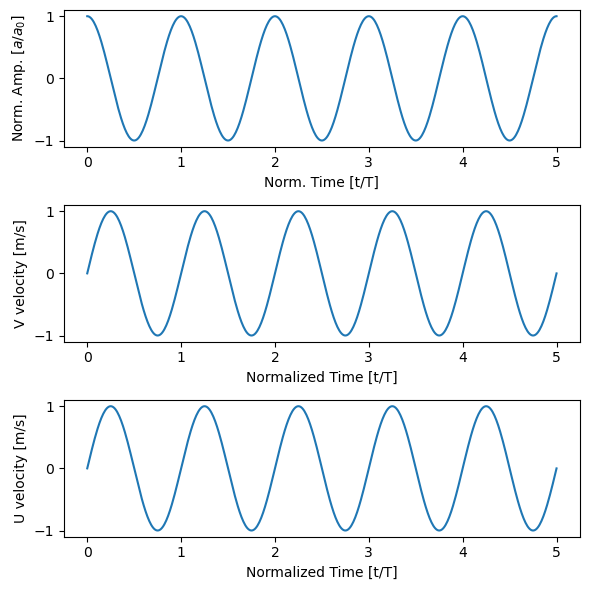

In [6]:
# Plot the U velocity at (1,1)

# Get the indices closest to the desired location
x_index = find_closest_value_index(x, 1.0)
y_index = find_closest_value_index(y, 1.0)

# Create the plot
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (6, 6))

# NOTE: The amplitudes are the same for both velocities

index = 0
eta_amplitude = eta[x_index, y_index, :].max()
axs[index].plot(t/wave_period, eta[x_index, y_index, :]/eta_amplitude)

# Plot the U velocity data
index = 1
U_amplitude = U[x_index, y_index, :].max()
axs[index].plot(t/wave_period, U[x_index, y_index, :]/U_amplitude)

# Plot the y velocity data
index = 2
V_amplitude = V[x_index, y_index, :].max()
axs[index].plot(t/wave_period, V[x_index, y_index, :]/V_amplitude)


# Format the plots
index = 0
axs[index].set_xlabel("Norm. Time [t/T]")
axs[index].set_ylabel("Norm. Amp. [$a/a_{0}$]")

index = 2
axs[index].set_xlabel("Normalized Time [t/T]")
axs[index].set_ylabel("U velocity [m/s]")

index = 1
axs[index].set_xlabel("Normalized Time [t/T]")
axs[index].set_ylabel("V velocity [m/s]")

plt.tight_layout()
plt.show()
# plt.plot(t, V[1, 1, :])

##### Animation

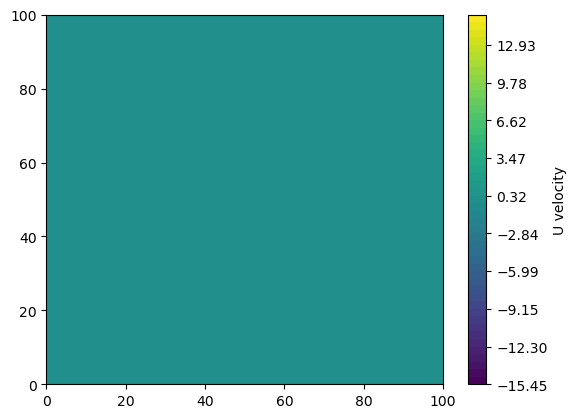

In [7]:
# Flag that controls if the animation is created. It takes about a minute to create the animation
make_animation = False

# Calculate the global min and max values of U
U_min = np.min(U)
U_max = np.max(U)

# Set up the figure and axis
fig, ax = plt.subplots()

levels = np.linspace(U_min, U_max, 50)

# Create the initial contour plot with global vmin and vmax
# cax = ax.contourf(X[:, :, 0], Y[:, :, 0], U[:, :, 0], levels=50, cmap='viridis', vmin=U_min, vmax=U_max)
cax = ax.contourf(X[:, :, 0], Y[:, :, 0], U[:, :, 0], levels=levels, cmap='viridis', vmin=U_min, vmax=U_max)

# Add colorbar with label
cbar = fig.colorbar(cax)
cbar.set_label('U velocity')

def animate(i):
    ax.clear()
    cax = ax.contourf(X[:, :, 0], Y[:, :, 0], U[:, :, i], levels=levels, cmap='viridis', vmin=U_min, vmax=U_max)

    ax.set_title(f'U velocity at time t/T={t[i]/wave_period:.2f}')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    return cax

if make_animation:
    ani = animation.FuncAnimation(fig, animate, frames=len(t), repeat=True)

    # Save the animation as a video file
    ani.save('analytical_U_velocity.gif', writer='ffmpeg', fps=30)  # Adjust fps if needed

    # Show the animation
    plt.show()

#### Surface Elevation at selected times

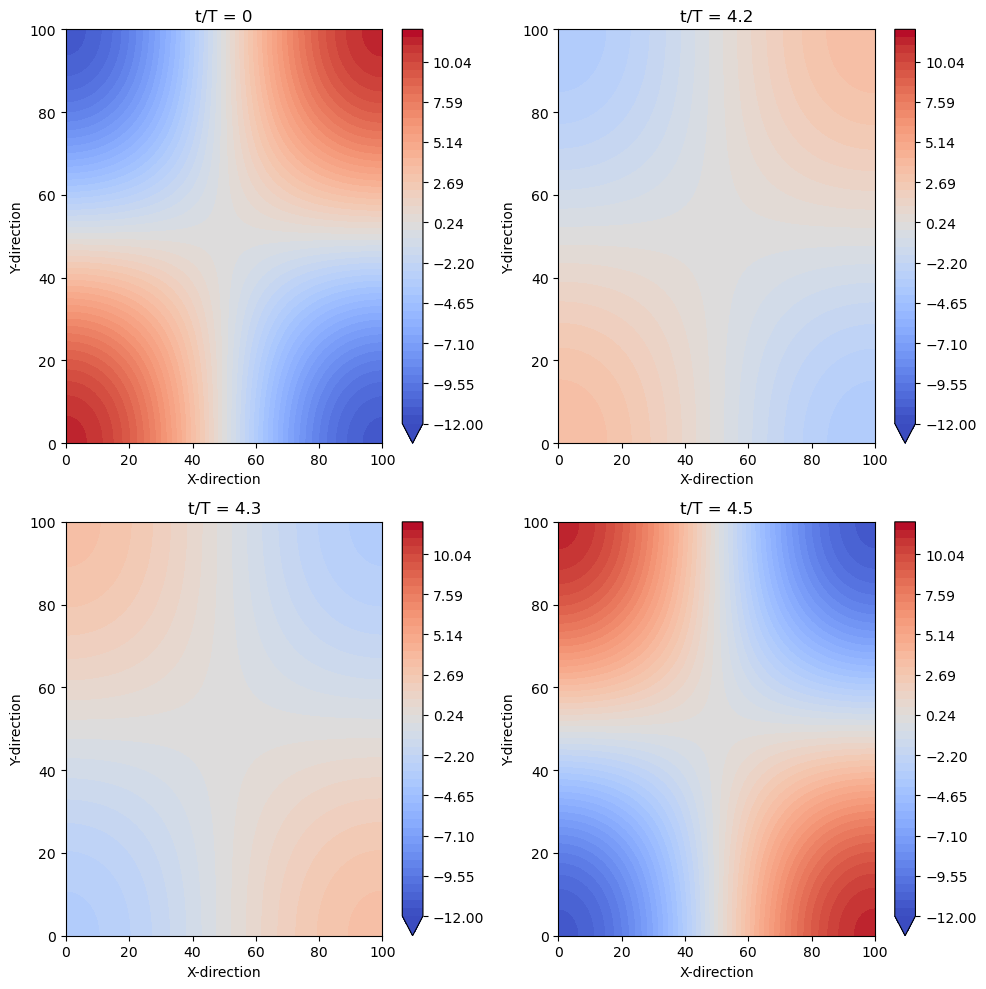

In [8]:
# create the plot
fig, axs = plt.subplots(nrows =2, ncols = 2, figsize = (10,10))
times = [0, 4.2, 4.3, 4.5]

# Get the index of the closest value to selected times
time_index = [find_closest_value_index(t/wave_period, selec) for selec in times]

# Analytical solution
i = 0
j = 0

levels = np.linspace(0-12, 12, 50)

for i, ax in enumerate(axs.reshape(-1)):
    index = time_index[i]
    cax= ax.contourf(X[:, : , index], Y[:, : , index], eta[:, : , index], levels = levels, cmap = "coolwarm", extend = "min")

    # Add colorbar with label
    cbar = fig.colorbar(cax)
    ax.set_title('t/T = {}'.format(times[i]))
    ax.set_xlabel('X-direction')
    ax.set_ylabel('Y-direction')

plt.tight_layout()
plt.show()
